# All classes

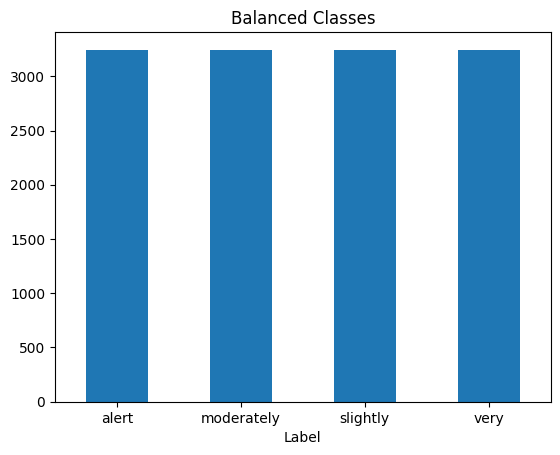

In [ ]:
# Data splitting and cleaning
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
# df = pd.read_csv("Windowed and Cleaned Data/P5_S1_windowed_interpolated.csv")
df = pd.read_csv("Classification_Combined_Data/S1_combined_cleaned_windowed.csv")

# ❗ Remove rows with '1back' and '2back' labels
df = df[~df['Label'].isin(['1back', '2back'])].reset_index(drop=True)

# Encode the label
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

# Features and target
X = df.drop(columns=['window_start', 'window_end', 'ID', 'Label'])
y = df['Label']

# Standardize features
scaler = StandardScaler()

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X, y)

# Display class counts after balancing
pd.Series(y_train).value_counts().plot(kind='bar', title='Balanced Classes')
plt.xticks(ticks=range(len(le.classes_)), labels=le.classes_, rotation=0)
plt.show()

# Train/val/test split: 70-15-15
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.30, stratify=y_train, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

X_scaled_train = scaler.fit_transform(X_train)
X_scaled_val = scaler.transform(X_val)
X_scaled_test = scaler.transform(X_test)

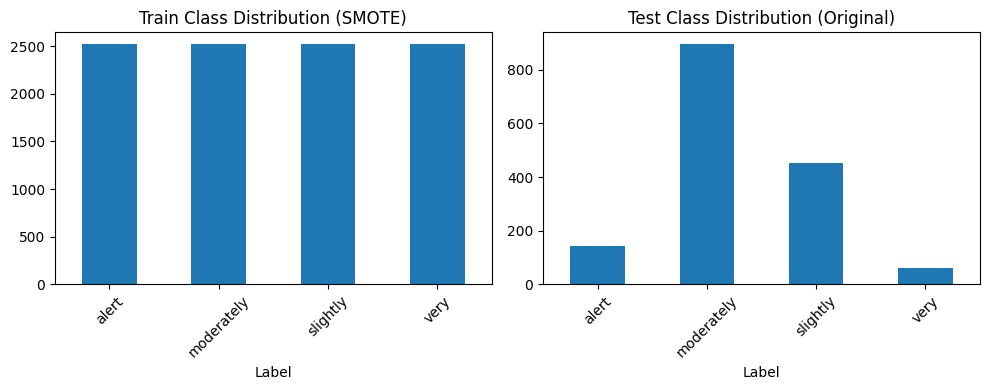

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load pre-split datasets (already normalized per participant)
train_df = pd.read_csv("Classification_Combined_Data/S1_train_cleaned_windowed.csv")
test_df = pd.read_csv("Classification_Combined_Data/S1_test_cleaned_windowed.csv")

# Filter out unwanted labels
unwanted_labels = ['1back', '2back']
train_df = train_df[~train_df['Label'].isin(unwanted_labels)].reset_index(drop=True)
test_df = test_df[~test_df['Label'].isin(unwanted_labels)].reset_index(drop=True)

# Drop N/A values
train_df = train_df.dropna()
test_df = test_df.dropna()

# Encode labels
le = LabelEncoder()
train_df['Label'] = le.fit_transform(train_df['Label'])
test_df['Label'] = le.transform(test_df['Label'])

# Extract features and targets
drop_cols = ['window_start', 'window_end', 'ID', 'Label']
X_train_raw = train_df.drop(columns=drop_cols)
y_train_raw = train_df['Label']

X_test = test_df.drop(columns=drop_cols)
y_test = test_df['Label']

# Apply SMOTE to training set only
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

# Plot class distributions
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
pd.Series(y_train).value_counts().sort_index().plot(kind='bar', title='Train Class Distribution (SMOTE)')
plt.xticks(ticks=range(len(le.classes_)), labels=le.classes_, rotation=45)

plt.subplot(1, 2, 2)
pd.Series(y_test).value_counts().sort_index().plot(kind='bar', title='Test Class Distribution (Original)')
plt.xticks(ticks=range(len(le.classes_)), labels=le.classes_, rotation=45)

plt.tight_layout()
plt.show()

# Split training into train/validation
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=42
)

Random Forest Results:
               precision    recall  f1-score   support

       alert       0.13      0.21      0.16       143
  moderately       0.70      0.55      0.61       895
    slightly       0.39      0.50      0.44       453
        very       0.12      0.08      0.10        61

    accuracy                           0.48      1552
   macro avg       0.34      0.33      0.33      1552
weighted avg       0.53      0.48      0.50      1552



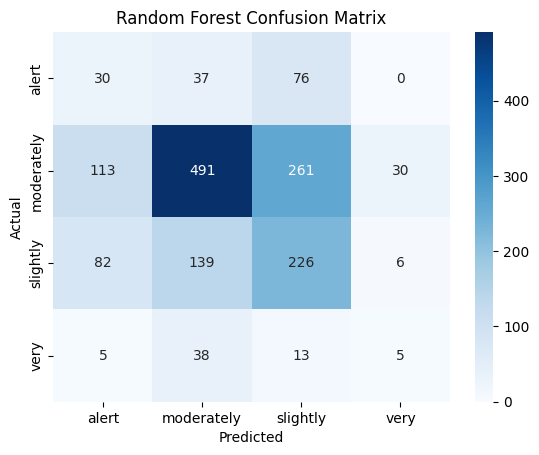

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Report
print("Random Forest Results:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

/Users/aaryannagpal1/Documents/Thesis/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:11:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results:
               precision    recall  f1-score   support

       alert       0.12      0.38      0.19       143
  moderately       0.70      0.50      0.58       895
    slightly       0.37      0.32      0.34       453
        very       0.08      0.10      0.09        61

    accuracy                           0.42      1552
   macro avg       0.32      0.33      0.30      1552
weighted avg       0.52      0.42      0.46      1552



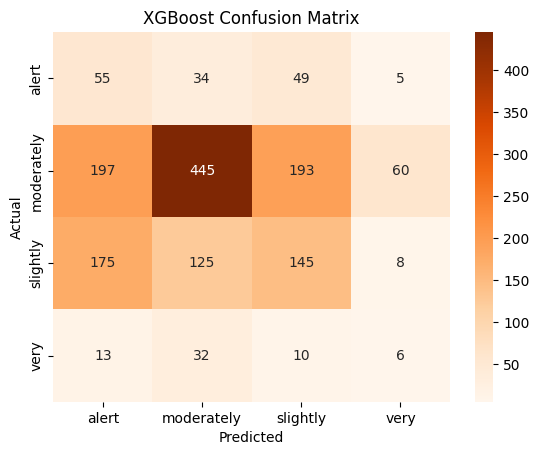

In [5]:
# XGBoost
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)

# Evaluation
y_pred = xgb.predict(X_test)
print("XGBoost Results:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Iteration 1, loss = 1.32318724
Validation score: 0.428571
Iteration 2, loss = 1.22150526
Validation score: 0.460317
Iteration 3, loss = 1.18400212
Validation score: 0.474206
Iteration 4, loss = 1.16358190
Validation score: 0.483135
Iteration 5, loss = 1.14383426
Validation score: 0.484127
Iteration 6, loss = 1.12745075
Validation score: 0.493056
Iteration 7, loss = 1.10906985
Validation score: 0.493056
Iteration 8, loss = 1.09292144
Validation score: 0.513889
Iteration 9, loss = 1.08020016
Validation score: 0.516865
Iteration 10, loss = 1.06647413
Validation score: 0.528770
Iteration 11, loss = 1.05359842
Validation score: 0.533730
Iteration 12, loss = 1.04234816
Validation score: 0.551587
Iteration 13, loss = 1.03170414
Validation score: 0.542659
Iteration 14, loss = 1.01949810
Validation score: 0.562500
Iteration 15, loss = 1.00937939
Validation score: 0.572421
Iteration 16, loss = 1.00050127
Validation score: 0.557540
Iteration 17, loss = 0.99225744
Validation score: 0.578373
Iterat

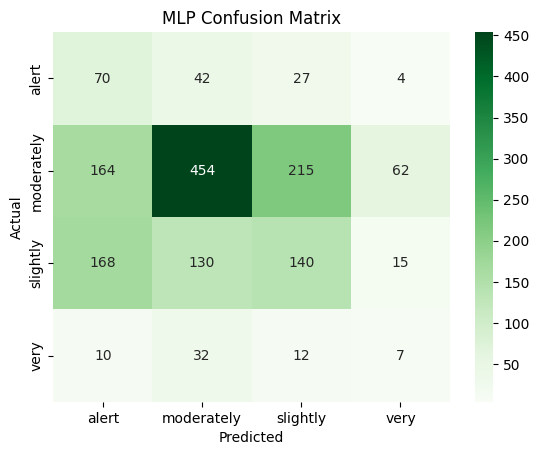

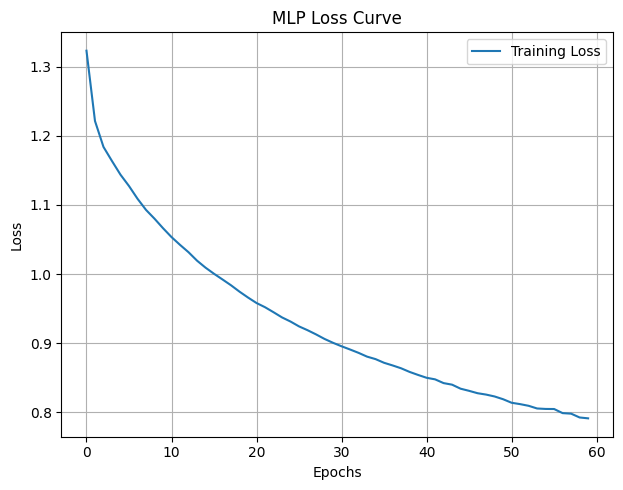

In [6]:
# MLP
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=300,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=True,
    n_iter_no_change=10
)

mlp.fit(X_train, y_train)

# Evaluation
y_pred = mlp.predict(X_test)
print("MLP Results:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Loss Curve
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(mlp.loss_curve_, label='Training Loss')
plt.title("MLP Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 3 Class

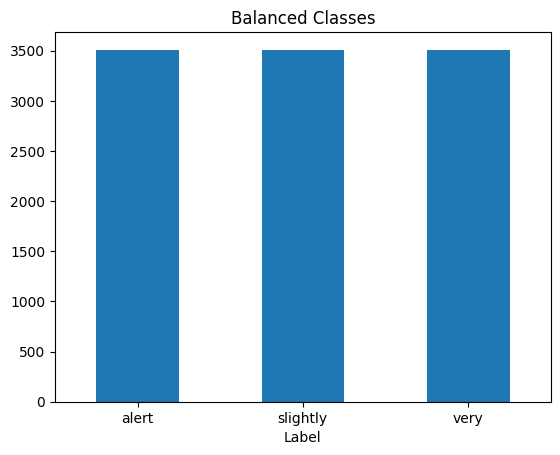

In [14]:
# Data splitting and cleaning
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
# df = pd.read_csv("Windowed and Cleaned Data/P5_S1_windowed_interpolated.csv")
df = pd.read_csv("Classification_Combined_Data/S1_combined_cleaned_windowed.csv")

# Label map
label_map = {
    'alert': 'alert',
    'slightly': 'slightly',
    'moderately': 'very',
    'very': 'very'
}

# Apply label mapping
df['Label'] = df['Label'].map(label_map)

# Drop rows with NaN labels
df = df.dropna(subset=['Label'])

# ❗ Remove rows with '1back' and '2back' labels
df = df[~df['Label'].isin(['1back', '2back'])].reset_index(drop=True)

# Encode the label
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

# Features and target
X = df.drop(columns=['window_start', 'window_end', 'ID', 'Label'])
y = df['Label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_scaled, y)

# Display class counts after balancing
pd.Series(y_train).value_counts().plot(kind='bar', title='Balanced Classes')
plt.xticks(ticks=range(len(le.classes_)), labels=le.classes_, rotation=0)
plt.show()

# Train/val/test split: 70-15-15
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.30, stratify=y_train, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

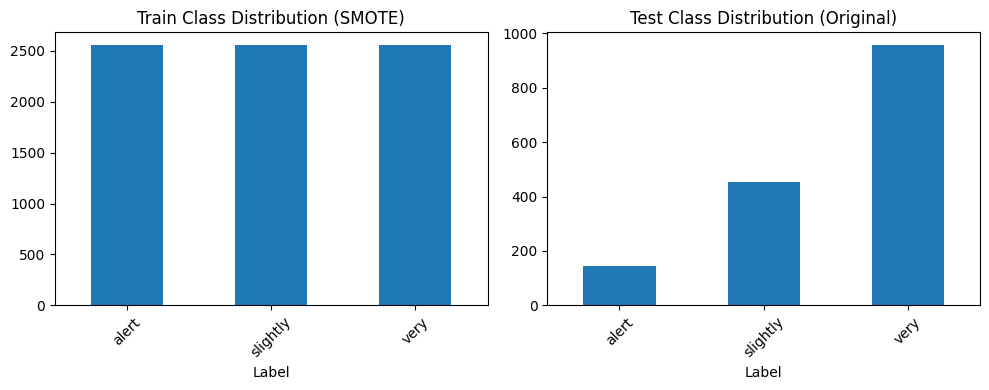

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load pre-split datasets (already normalized per participant)
train_df = pd.read_csv("Classification_Combined_Data/S1_train_cleaned_windowed.csv")
test_df = pd.read_csv("Classification_Combined_Data/S1_test_cleaned_windowed.csv")

# Filter out unwanted labels
unwanted_labels = ['1back', '2back']
train_df = train_df[~train_df['Label'].isin(unwanted_labels)].reset_index(drop=True)
test_df = test_df[~test_df['Label'].isin(unwanted_labels)].reset_index(drop=True)

# Label map
label_map = {
    'alert': 'alert',
    'slightly': 'slightly',
    'moderately': 'very',
    'very': 'very'
}

# Apply label mapping
train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)

# Drop N/A values
train_df = train_df.dropna()
test_df = test_df.dropna()

# Encode labels
le = LabelEncoder()
train_df['Label'] = le.fit_transform(train_df['Label'])
test_df['Label'] = le.transform(test_df['Label'])

# Extract features and targets
drop_cols = ['window_start', 'window_end', 'ID', 'Label']
X_train_raw = train_df.drop(columns=drop_cols)
y_train_raw = train_df['Label']

X_test = test_df.drop(columns=drop_cols)
y_test = test_df['Label']

# Apply SMOTE to training set only
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

# Plot class distributions
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
pd.Series(y_train).value_counts().sort_index().plot(kind='bar', title='Train Class Distribution (SMOTE)')
plt.xticks(ticks=range(len(le.classes_)), labels=le.classes_, rotation=45)

plt.subplot(1, 2, 2)
pd.Series(y_test).value_counts().sort_index().plot(kind='bar', title='Test Class Distribution (Original)')
plt.xticks(ticks=range(len(le.classes_)), labels=le.classes_, rotation=45)

plt.tight_layout()
plt.show()

# Split training into train/validation
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=42
)

Random Forest Results:
               precision    recall  f1-score   support

       alert       0.14      0.25      0.18       143
    slightly       0.38      0.49      0.43       453
        very       0.75      0.57      0.65       956

    accuracy                           0.51      1552
   macro avg       0.42      0.43      0.42      1552
weighted avg       0.59      0.51      0.54      1552



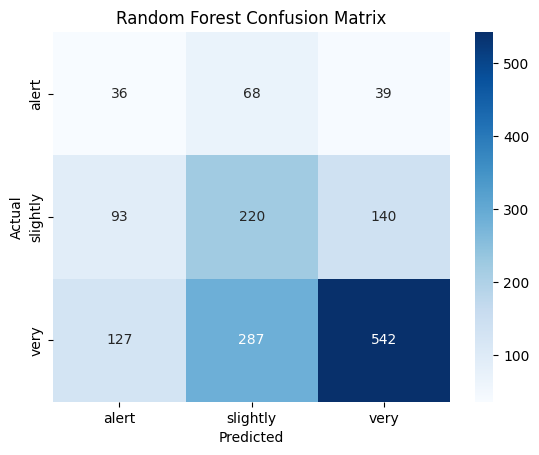

In [8]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluation
y_pred = rf.predict(X_test)
print("Random Forest Results:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

/Users/aaryannagpal1/Documents/Thesis/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:19:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results:
               precision    recall  f1-score   support

       alert       0.13      0.41      0.20       143
    slightly       0.36      0.40      0.38       453
        very       0.75      0.49      0.59       956

    accuracy                           0.45      1552
   macro avg       0.41      0.43      0.39      1552
weighted avg       0.58      0.45      0.49      1552



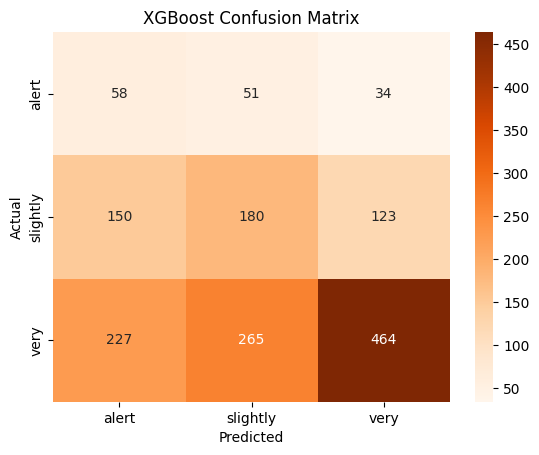

In [9]:
# XGBoost
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)

# Evaluation
y_pred = xgb.predict(X_test)
print("XGBoost Results:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Iteration 1, loss = 1.07895110
Validation score: 0.438070
Iteration 2, loss = 1.02506587
Validation score: 0.445893
Iteration 3, loss = 1.00742764
Validation score: 0.466754
Iteration 4, loss = 0.99733567
Validation score: 0.470665
Iteration 5, loss = 0.99035361
Validation score: 0.458931
Iteration 6, loss = 0.98367428
Validation score: 0.462842
Iteration 7, loss = 0.97731417
Validation score: 0.470665
Iteration 8, loss = 0.97139133
Validation score: 0.464146
Iteration 9, loss = 0.96605718
Validation score: 0.485007
Iteration 10, loss = 0.96210267
Validation score: 0.478488
Iteration 11, loss = 0.95710438
Validation score: 0.491525
Iteration 12, loss = 0.95432499
Validation score: 0.495437
Iteration 13, loss = 0.94919524
Validation score: 0.492829
Iteration 14, loss = 0.94476191
Validation score: 0.498044
Iteration 15, loss = 0.94227365
Validation score: 0.495437
Iteration 16, loss = 0.93853397
Validation score: 0.507171
Iteration 17, loss = 0.93493279
Validation score: 0.496741
Iterat

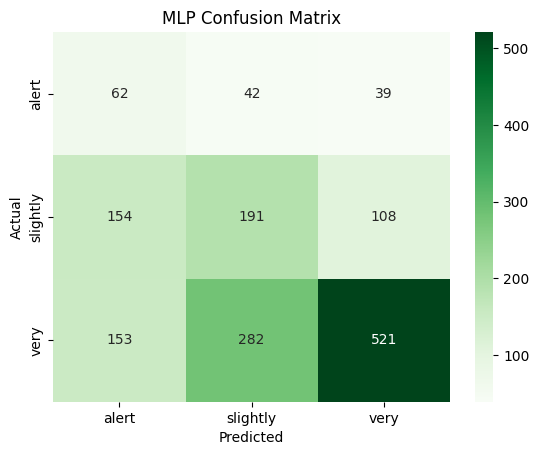

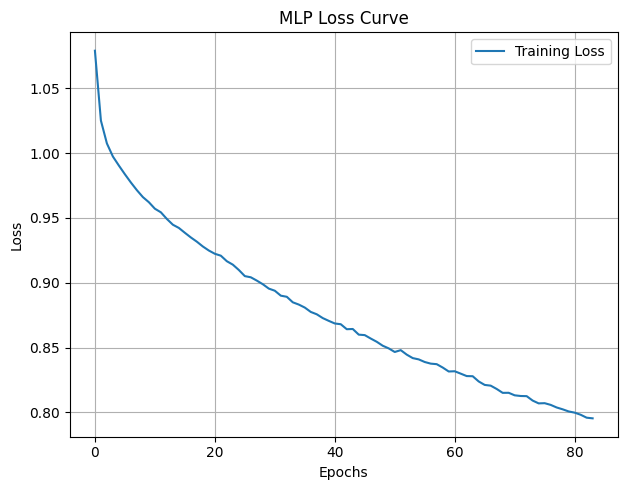

In [10]:
# MLP
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=300,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=True,
    n_iter_no_change=10
)

mlp.fit(X_train, y_train)

# Evaluation
y_pred = mlp.predict(X_test)
print("MLP Results:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Loss Curve
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(mlp.loss_curve_, label='Training Loss')
plt.title("MLP Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# All classes (No slightly)

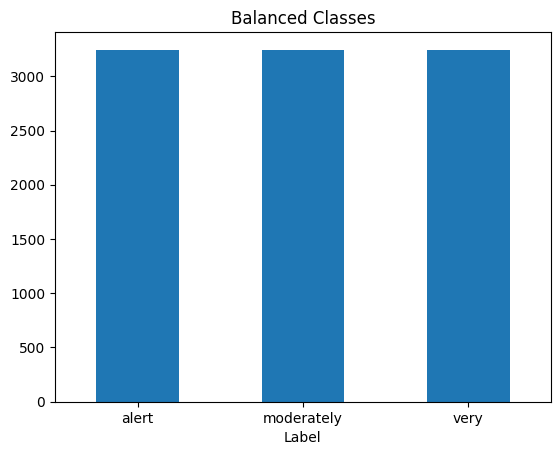

In [18]:
# Data splitting and cleaning
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
# df = pd.read_csv("Windowed and Cleaned Data/P5_S1_windowed_interpolated.csv")
df = pd.read_csv("Classification_Combined_Data/S1_combined_cleaned_windowed.csv")

# ❗ Remove rows with '1back', '2back' and 'slightly' labels
df = df[~df['Label'].isin(['1back', '2back', 'slightly'])].reset_index(drop=True)

# Encode the label
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

# Features and target
X = df.drop(columns=['window_start', 'window_end', 'ID', 'Label'])
y = df['Label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_scaled, y)

# Display class counts after balancing
pd.Series(y_train).value_counts().plot(kind='bar', title='Balanced Classes')
plt.xticks(ticks=range(len(le.classes_)), labels=le.classes_, rotation=0)
plt.show()

# Train/val/test split: 70-15-15
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.30, stratify=y_train, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

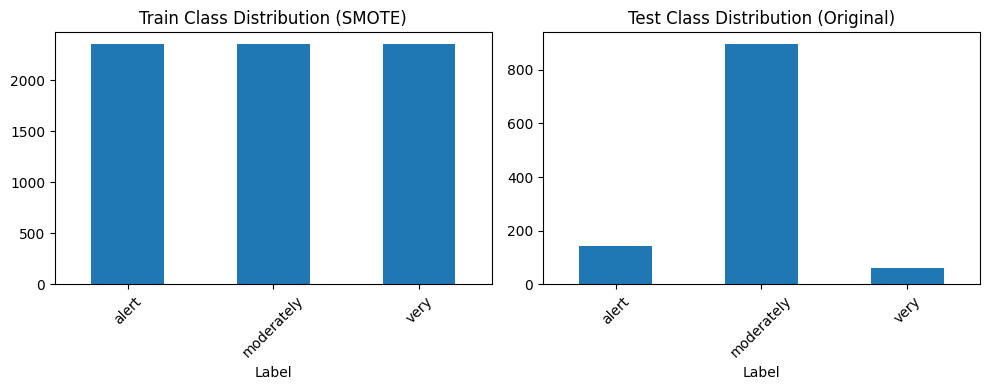

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load pre-split datasets (already normalized per participant)
train_df = pd.read_csv("Classification_Combined_Data/S1_train_cleaned_windowed.csv")
test_df = pd.read_csv("Classification_Combined_Data/S1_test_cleaned_windowed.csv")

# Filter out unwanted labels
unwanted_labels = ['1back', '2back', 'slightly']
train_df = train_df[~train_df['Label'].isin(unwanted_labels)].reset_index(drop=True)
test_df = test_df[~test_df['Label'].isin(unwanted_labels)].reset_index(drop=True)

# Label map
label_map = {
    'alert': 'alert',
    'moderately': 'moderately',
    'very': 'very'
}

# Apply label mapping
train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)

# Drop N/A values
train_df = train_df.dropna()
test_df = test_df.dropna()

# Encode labels
le = LabelEncoder()
train_df['Label'] = le.fit_transform(train_df['Label'])
test_df['Label'] = le.transform(test_df['Label'])

# Extract features and targets
drop_cols = ['window_start', 'window_end', 'ID', 'Label']
X_train_raw = train_df.drop(columns=drop_cols)
y_train_raw = train_df['Label']

X_test = test_df.drop(columns=drop_cols)
y_test = test_df['Label']

# Apply SMOTE to training set only
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

# Plot class distributions
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
pd.Series(y_train).value_counts().sort_index().plot(kind='bar', title='Train Class Distribution (SMOTE)')
plt.xticks(ticks=range(len(le.classes_)), labels=le.classes_, rotation=45)

plt.subplot(1, 2, 2)
pd.Series(y_test).value_counts().sort_index().plot(kind='bar', title='Test Class Distribution (Original)')
plt.xticks(ticks=range(len(le.classes_)), labels=le.classes_, rotation=45)

plt.tight_layout()
plt.show()

# Split training into train/validation
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=42
)

Random Forest Results:
               precision    recall  f1-score   support

       alert       0.28      0.53      0.37       143
  moderately       0.85      0.76      0.80       895
        very       0.09      0.05      0.06        61

    accuracy                           0.69      1099
   macro avg       0.41      0.45      0.41      1099
weighted avg       0.74      0.69      0.70      1099



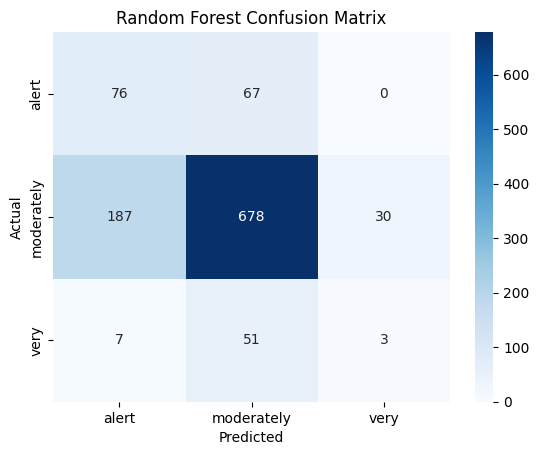

In [12]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluation
y_pred = rf.predict(X_test)
print("Random Forest Results:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

/Users/aaryannagpal1/Documents/Thesis/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:23:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results:
               precision    recall  f1-score   support

       alert       0.23      0.59      0.33       143
  moderately       0.86      0.63      0.72       895
        very       0.06      0.08      0.07        61

    accuracy                           0.59      1099
   macro avg       0.38      0.43      0.38      1099
weighted avg       0.73      0.59      0.64      1099



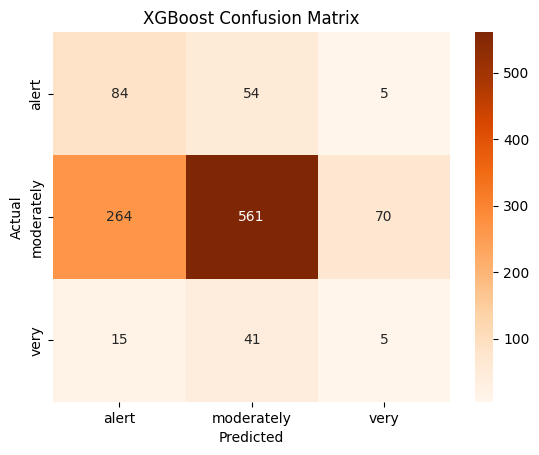

In [13]:
# XGBoost
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)

# Evaluation
y_pred = xgb.predict(X_test)
print("XGBoost Results:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Iteration 1, loss = 1.03516807
Validation score: 0.575887
Iteration 2, loss = 0.91802601
Validation score: 0.601418
Iteration 3, loss = 0.86925064
Validation score: 0.611348
Iteration 4, loss = 0.84075707
Validation score: 0.626950
Iteration 5, loss = 0.81806979
Validation score: 0.639716
Iteration 6, loss = 0.79726778
Validation score: 0.641135
Iteration 7, loss = 0.78052691
Validation score: 0.645390
Iteration 8, loss = 0.76478424
Validation score: 0.643972
Iteration 9, loss = 0.74949728
Validation score: 0.655319
Iteration 10, loss = 0.73447997
Validation score: 0.669504
Iteration 11, loss = 0.72070794
Validation score: 0.659574
Iteration 12, loss = 0.70776853
Validation score: 0.670922
Iteration 13, loss = 0.69583196
Validation score: 0.682270
Iteration 14, loss = 0.68502330
Validation score: 0.685106
Iteration 15, loss = 0.67524551
Validation score: 0.700709
Iteration 16, loss = 0.66782881
Validation score: 0.695035
Iteration 17, loss = 0.65678287
Validation score: 0.695035
Iterat

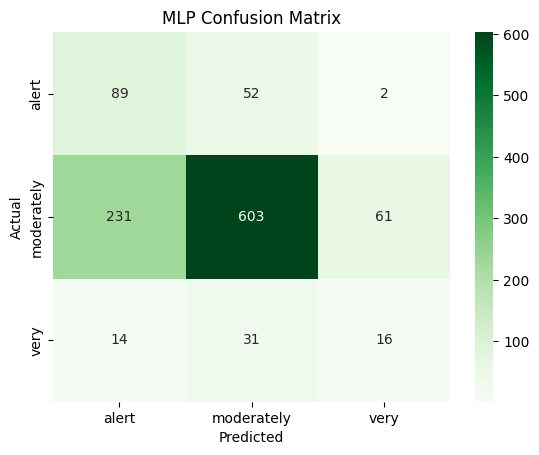

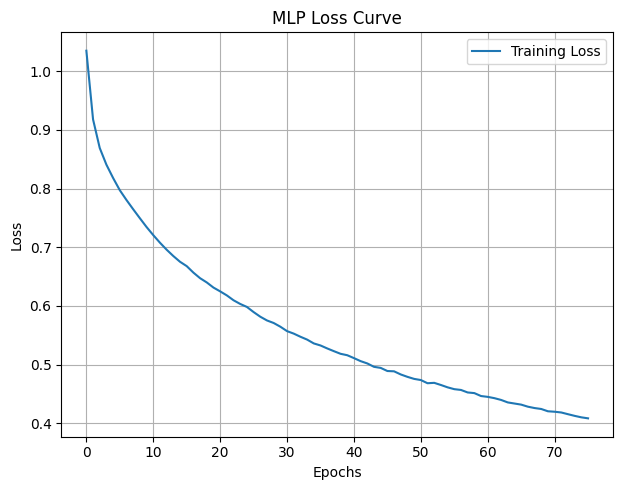

In [14]:
# MLP
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=300,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=True,
    n_iter_no_change=10
)

mlp.fit(X_train, y_train)

# Evaluation
y_pred = mlp.predict(X_test)
print("MLP Results:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Loss Curve
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(mlp.loss_curve_, label='Training Loss')
plt.title("MLP Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 2 Class (No slightly)

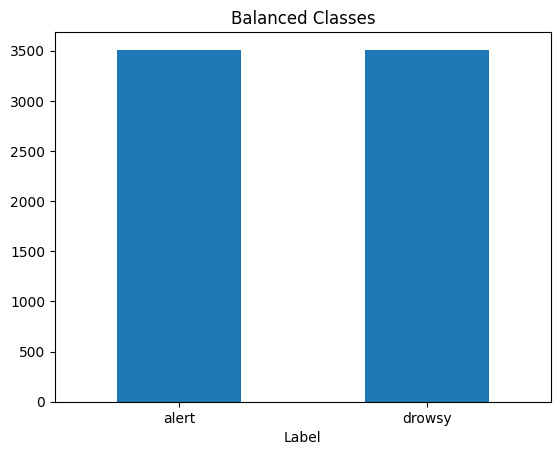

In [22]:
# Data splitting and cleaning
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
# df = pd.read_csv("Windowed and Cleaned Data/P5_S1_windowed_interpolated.csv")
df = pd.read_csv("Classification_Combined_Data/S1_combined_cleaned_windowed.csv")

# Label map
label_map = {
    'alert': 'alert',
    'moderately': 'drowsy',
    'very': 'drowsy'
}

# Apply label mapping
df['Label'] = df['Label'].map(label_map)

# Drop rows with NaN labels
df = df.dropna(subset=['Label'])

# ❗ Remove rows with '1back', '2back' and 'slightly' labels
df = df[~df['Label'].isin(['1back', '2back', 'slightly'])].reset_index(drop=True)

# Encode the label
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

# Features and target
X = df.drop(columns=['window_start', 'window_end', 'ID', 'Label'])
y = df['Label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_scaled, y)

# Display class counts after balancing
pd.Series(y_train).value_counts().plot(kind='bar', title='Balanced Classes')
plt.xticks(ticks=range(len(le.classes_)), labels=le.classes_, rotation=0)
plt.show()

# Train/val/test split: 70-15-15
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.30, stratify=y_train, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

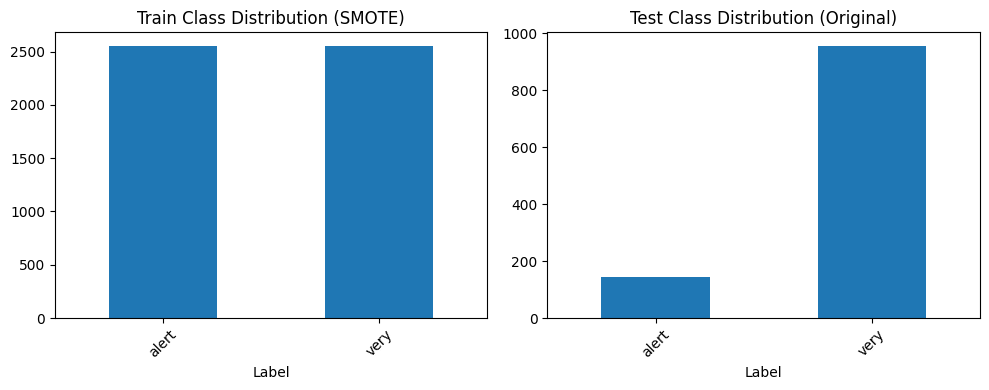

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load pre-split datasets (already normalized per participant)
train_df = pd.read_csv("Classification_Combined_Data/S1_train_cleaned_windowed.csv")
test_df = pd.read_csv("Classification_Combined_Data/S1_test_cleaned_windowed.csv")

# Filter out unwanted labels
unwanted_labels = ['1back', '2back', 'slightly']
train_df = train_df[~train_df['Label'].isin(unwanted_labels)].reset_index(drop=True)
test_df = test_df[~test_df['Label'].isin(unwanted_labels)].reset_index(drop=True)

# Label map
label_map = {
    'alert': 'alert',
    'moderately': 'very',
    'very': 'very'
}

# Apply label mapping
train_df['Label'] = train_df['Label'].map(label_map)
test_df['Label'] = test_df['Label'].map(label_map)

# Drop N/A values
train_df = train_df.dropna()
test_df = test_df.dropna()

# Encode labels
le = LabelEncoder()
train_df['Label'] = le.fit_transform(train_df['Label'])
test_df['Label'] = le.transform(test_df['Label'])

# Extract features and targets
drop_cols = ['window_start', 'window_end', 'ID', 'Label']
X_train_raw = train_df.drop(columns=drop_cols)
y_train_raw = train_df['Label']

X_test = test_df.drop(columns=drop_cols)
y_test = test_df['Label']

# Apply SMOTE to training set only
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train_raw, y_train_raw)

# Plot class distributions
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
pd.Series(y_train).value_counts().sort_index().plot(kind='bar', title='Train Class Distribution (SMOTE)')
plt.xticks(ticks=range(len(le.classes_)), labels=le.classes_, rotation=45)

plt.subplot(1, 2, 2)
pd.Series(y_test).value_counts().sort_index().plot(kind='bar', title='Test Class Distribution (Original)')
plt.xticks(ticks=range(len(le.classes_)), labels=le.classes_, rotation=45)

plt.tight_layout()
plt.show()

# Split training into train/validation
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=42
)

Random Forest Results:
               precision    recall  f1-score   support

       alert       0.27      0.52      0.35       143
        very       0.92      0.78      0.84       956

    accuracy                           0.75      1099
   macro avg       0.59      0.65      0.60      1099
weighted avg       0.83      0.75      0.78      1099



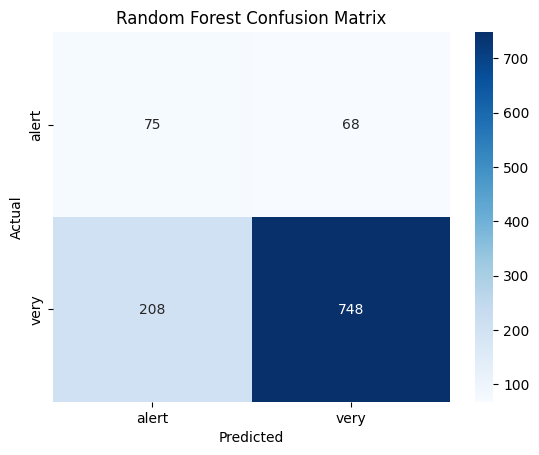

In [16]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluation
y_pred = rf.predict(X_test)
print("Random Forest Results:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

XGBoost Results:
               precision    recall  f1-score   support

       alert       0.22      0.62      0.33       143
        very       0.92      0.67      0.78       956

    accuracy                           0.67      1099
   macro avg       0.57      0.65      0.55      1099
weighted avg       0.83      0.67      0.72      1099



/Users/aaryannagpal1/Documents/Thesis/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:25:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


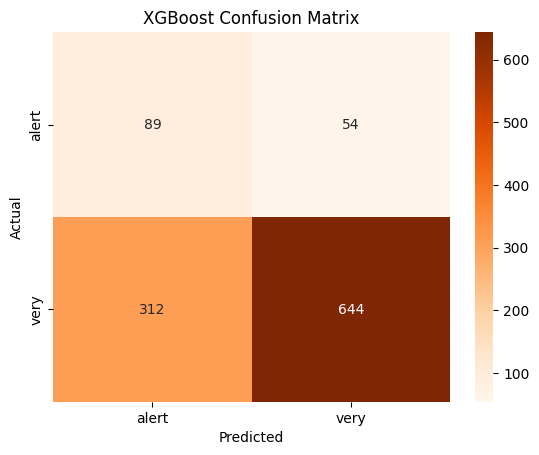

In [17]:
# XGBoost
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)

# Evaluation
y_pred = xgb.predict(X_test)
print("XGBoost Results:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Iteration 1, loss = 0.64847328
Validation score: 0.675147
Iteration 2, loss = 0.60060065
Validation score: 0.667319
Iteration 3, loss = 0.58565910
Validation score: 0.673190
Iteration 4, loss = 0.57822462
Validation score: 0.688845
Iteration 5, loss = 0.57189830
Validation score: 0.698630
Iteration 6, loss = 0.56578604
Validation score: 0.702544
Iteration 7, loss = 0.56165835
Validation score: 0.710372
Iteration 8, loss = 0.55639025
Validation score: 0.706458
Iteration 9, loss = 0.55220915
Validation score: 0.722114
Iteration 10, loss = 0.54758718
Validation score: 0.722114
Iteration 11, loss = 0.54486992
Validation score: 0.727984
Iteration 12, loss = 0.53977287
Validation score: 0.731898
Iteration 13, loss = 0.53610603
Validation score: 0.729941
Iteration 14, loss = 0.53276961
Validation score: 0.726027
Iteration 15, loss = 0.52870576
Validation score: 0.737769
Iteration 16, loss = 0.52555457
Validation score: 0.733855
Iteration 17, loss = 0.52217947
Validation score: 0.733855
Iterat

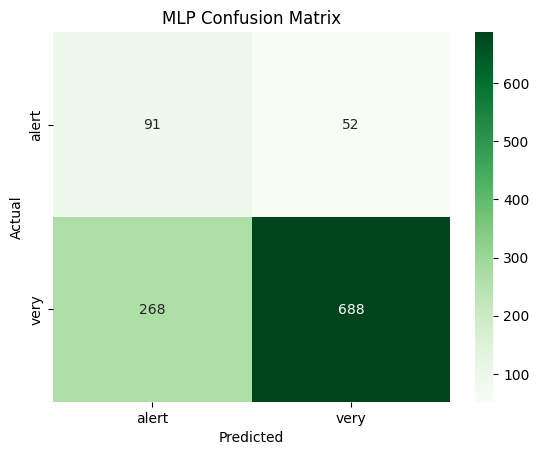

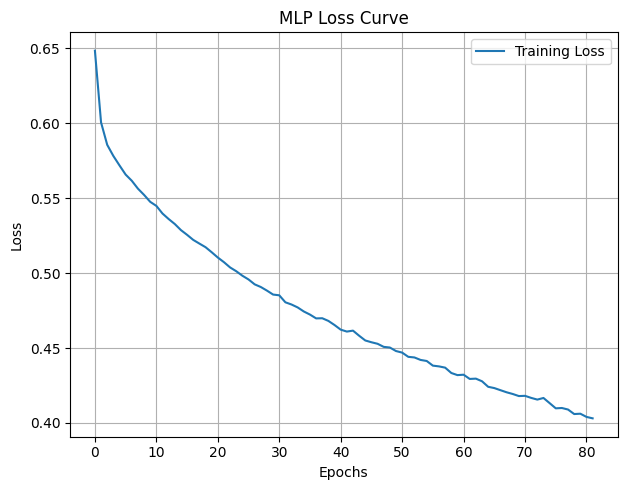

In [18]:
# MLP
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=300,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=True,
    n_iter_no_change=10
)

mlp.fit(X_train, y_train)

# Evaluation
y_pred = mlp.predict(X_test)
print("MLP Results:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Loss Curve
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(mlp.loss_curve_, label='Training Loss')
plt.title("MLP Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()